# Example clustering

This notebook shows some of the `clustering` algorithms used in the [Siamese Networks](https://github.com/yui-mhcp/siamese_networks) project. These algorithms are quite useful to identify clusters (labels) in the prediction of an encoder network (such as `Siamese Network`). 

Currently 3 algorithms are fully supported : 
- `KMeans` : the classical KMeans algorithm implemented in pure `tensorflow`. It also supports the `KMeans++` initialization.
- `Spectral Clustering` : special algorithm applying KMeans on the k lowest eigenvectors of the embeddings' matrix (via the SVD algorithm).
- `Label propagation` : a fancy custom algorithm I have implemented that propagates the label to the nearest neighbors of the current point (a kind of `BFS`-propagation of labels).

Each of these algorithms support a variant trying to discover *the best value of `k`* by testing multiple values, and finding an *elbow* in the scores. i.e. a `k` where the `Sum-Square Error (SSE)` score decreases less than before

**WARNING** currently the `label propagation` algorithm does not take into account the `k` parameter, meaning that it will create as many clusters as necessary, which can be higher or lower than the expected k ! In future version, this behavior will be partially solved by combining multiple clusters (when the expected k is lower than the number of created clusters). 

In [1]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.datasets import make_blobs, make_moons

from utils import plot_embedding, sample_df
from utils.embeddings import load_embedding, embeddings_to_np, compute_centroids
from utils.distance import find_clusters, evaluate_clustering

def run_and_evaluate(x, k, method, y = None, plot = True):
    if isinstance(method, list):
        for m in method:
            print('Run method {}...'.format(m))
            run_and_evaluate(x, k, m, y, plot)
        return
    
    x = tf.cast(x, tf.float32)
    
    config = method if isinstance(method, dict) else {'method' : method}
    clusters = find_clusters(x, k = k, ** config)
    
    if isinstance(clusters, tuple):
        centroids, assignment = clusters
    else:
        centroids, assignment = compute_centroids(x, clusters)[1], clusters

    print("Best k = {}".format(len(centroids)))

    if y is not None:
        acc, accs = evaluate_clustering(y, assignment)
        print("F1-score (mean : {:.2f}%) : {}".format(acc * 100, accs))

    if plot:
        plot_embedding(
            tf.concat([x, centroids], axis = 0),
            tf.concat([assignment, tf.range(tf.shape(centroids)[0], dtype = tf.int32)], axis = 0),
            marker = ['o'] * len(x) + ['x'] * len(centroids)
        )
    return assignment

directory = 'example_data'
filename  = 'embeddings_{}_voxforge.csv'

warnings.filterwarnings('ignore')

## Test on simple data

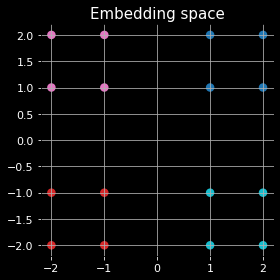

In [2]:
x = tf.cast([
    [1., 1.], [2., 2.], [2., 1.], [1., 2.],
    [-1., -1.], [-2., -2.], [-2., -1.], [-1., -2.],
    [-1., 1.], [-2., 2.], [-2., 1.], [-1., 2.],
    [1., -1.], [2., -2.], [2., -1.], [1., -2.]
], tf.float32)
y = tf.cast([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], tf.int32)

plot_embedding(x, y)

Run method kmeans...
Best k = 4
F1-score (mean : 100.00%) : [1. 1. 1. 1.]


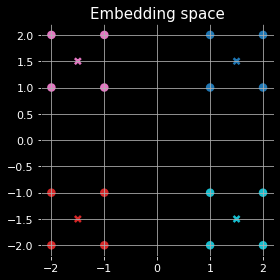

Run method spectral_clustering...
Best k = 4
F1-score (mean : 15.88%) : [0.23529413 0.         0.40000001 0.        ]


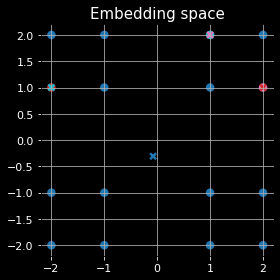

Run method {'method': 'label_propagation', 'k_nearest': 4}...
Best k = 4
F1-score (mean : 100.00%) : [1. 1. 1. 1.]


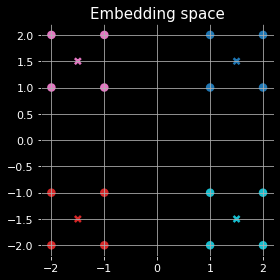

In [3]:
run_and_evaluate(
    x, y = y, k = 4, method = ['kmeans', 'spectral_clustering', {'method' : 'label_propagation', 'k_nearest' : 4}], plot = True
)

## Test on blobs

Blobs are vectors grouped according to a normal distribution, quite perfect to test the variable `KMeans` and the `label propagation` algorithms to check if they correcly detect well separable clusters.

The `KMeans` algorithm is highly influenced by its initialization, it is the reason why I implemented (like in `sklearn`) multiple initialization, and keep the best one. Even with this behaviour, it suffers from a high variance especially when the feature size is high. However, you can reduce the impact of this bad initialization by using the `init_method = kmeans_pp`  (default).

The `Spectral Clustering` method is not well suited for such clusters.

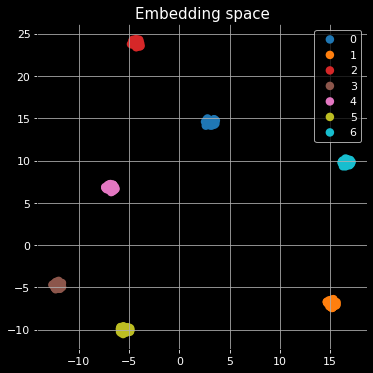

In [4]:
blobs_x, blobs_y = make_blobs(
    n_samples = 250, n_features = 128, centers = 7, cluster_std = 1., random_state = 10
)
plot_embedding(blobs_x, blobs_y)

Run method kmeans...
Best k = 7
F1-score (mean : 100.00%) : [1. 1. 1. 1. 1. 1. 1.]


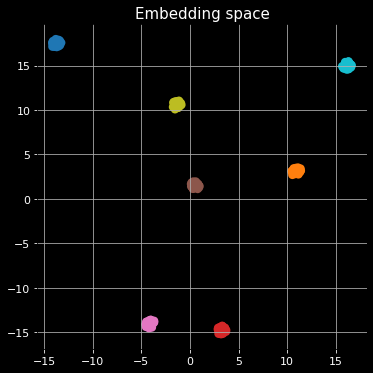

Run method spectral_clustering...
Best k = 9
F1-score (mean : 7.48%) : [0.25179857 0.         0.05405406 0.05405406 0.05405406 0.05405406
 0.05555555]


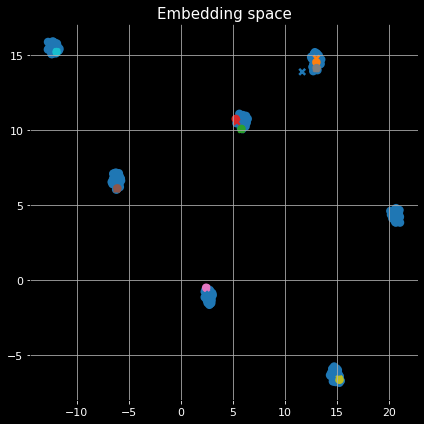

Run method {'method': 'label_propagation', 'k_nearest': 21}...
Best k = 7
F1-score (mean : 100.00%) : [1. 1. 1. 1. 1. 1. 1.]


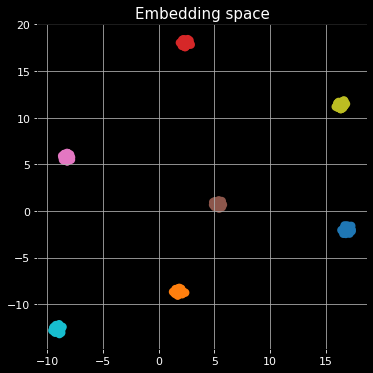

In [5]:
run_and_evaluate(
    blobs_x, y = blobs_y, k = range(5, 10), method = [
        'kmeans', 'spectral_clustering', {'method' : 'label_propagation', 'k_nearest' : 21}
    ], plot = True
)

## Test on circles

Circles are complex to cluster and to evaluate the quality of a clustering assignment, because they all share the same centroid, while visually beeing quite distinct from each other. In this kind of scenario, finding the best k is irrelevant according to the SSE metric (and it is currently the only one implemented), so you have to fix the k yourself. 

However, as you can find in the below graphs, the `spectral clustering` as well as the `label propagation` methods perfectly identify the 3 circles ! Furthermore, you can set `plot = True` for the `label_propagation` to see the evolution of labels, it is so funny !

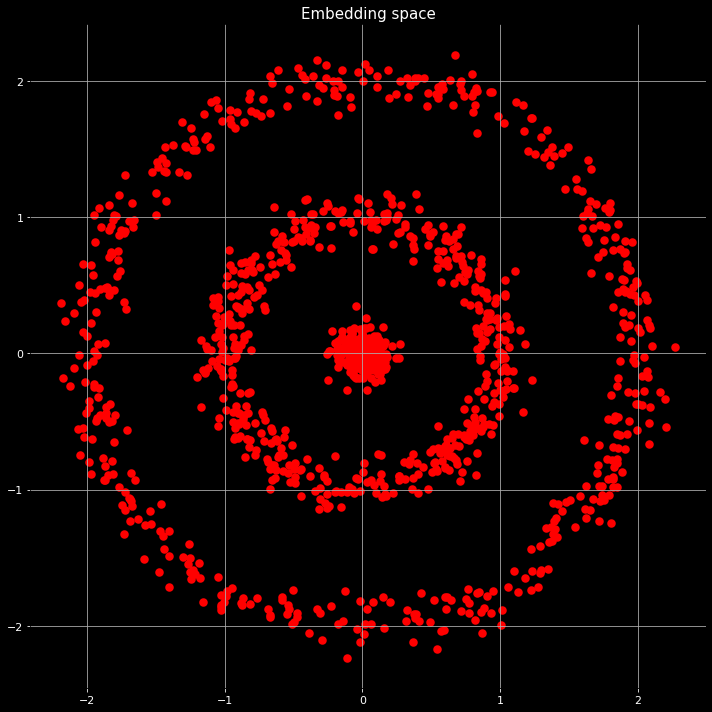

In [6]:
n_points, embedding_dim, n_circles = 1500, 2, 3
thetas = np.random.uniform(0, 2 * np.pi, n_points)

circles_x = (
    np.array([np.cos(thetas), np.sin(thetas)]) * (np.random.randint(n_circles, size = n_points) + 0.1 * np.random.randn(n_points))
).T

plot_embedding(circles_x)

Run method kmeans...
Best k = 3


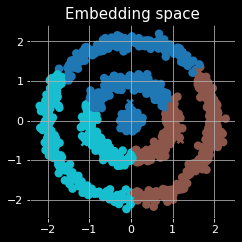

Run method spectral_clustering...
Best k = 3


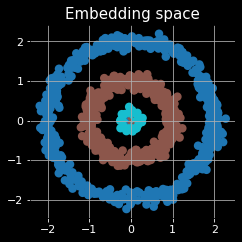

Run method {'method': 'label_propagation', 'k_nearest': 21}...
Best k = 3


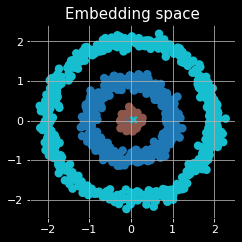

In [7]:
run_and_evaluate(
    circles_x, k = 3, method = [
        'kmeans', 'spectral_clustering', {'method' : 'label_propagation', 'k_nearest' : 21}
    ], plot = True
)

## Test on moons

As you can observe, moons have the exact same issues than circles : their centroid is not enough to have a good clustering score (so the SSE is not fully relevant). The kmeans therefore has some trouble to correcly cluster the points. A contrario, the 2 other methods perflectly cluster them !

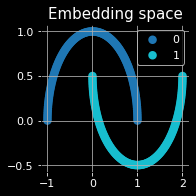

In [8]:
moons_x, moons_y = make_moons(
    n_samples = 250, random_state = 10
)

plot_embedding(moons_x, moons_y)

Run method kmeans...
Best k = 2
F1-score (mean : 74.80%) : [0.74900395 0.746988  ]


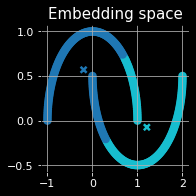

Run method spectral_clustering...
Best k = 2
F1-score (mean : 100.00%) : [1. 1.]


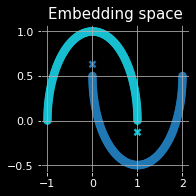

Run method {'method': 'label_propagation', 'k_nearest': 21}...
Best k = 2
F1-score (mean : 100.00%) : [1. 1.]


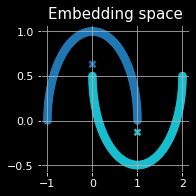

In [9]:
run_and_evaluate(
    moons_x, y = moons_y, k = 2, method = [
        'kmeans', 'spectral_clustering', {'method' : 'label_propagation', 'k_nearest' : 21}
    ], plot = True
)

## Test with embeddings

This test is the same as before but with real `embeddings` produced by the `siamese_networks` on the `VoxForge` dataset. Note that the performances are relatively low due to the quality of the embeddings which is clearly not perfect. More advanced models are now available, and creates more separable clusters.

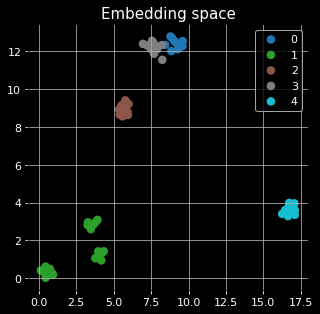

In [10]:
embeddings = load_embedding(directory, embedding_dim = 256, embedding_name = filename)

samples = sample_df(embeddings, n = 5, n_sample = 50)

ids = samples['id'].unique().tolist()
embeddings_x, embeddings_y = embeddings_to_np(samples), samples['id'].apply(lambda i: ids.index(i)).values

plot_embedding(embeddings_x, embeddings_y)

Run method kmeans...
Best k = 6
F1-score (mean : 98.95%) : [1.         1.         1.         0.94736838 1.        ]


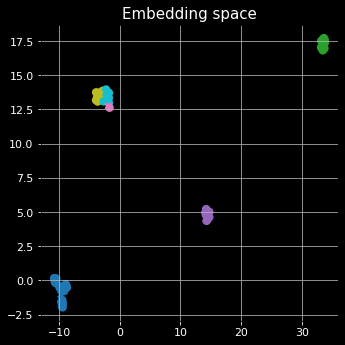

Run method spectral_clustering...
Best k = 3
F1-score (mean : 13.16%) : [0.29411763 0.         0.         0.18181819 0.18181819]


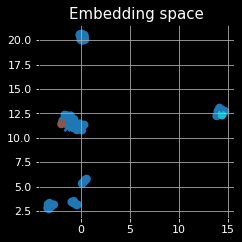

Run method {'method': 'label_propagation', 'k_nearest': 5}...
Best k = 9
F1-score (mean : 62.56%) : [0.66666669 0.46153849 1.         0.         1.        ]


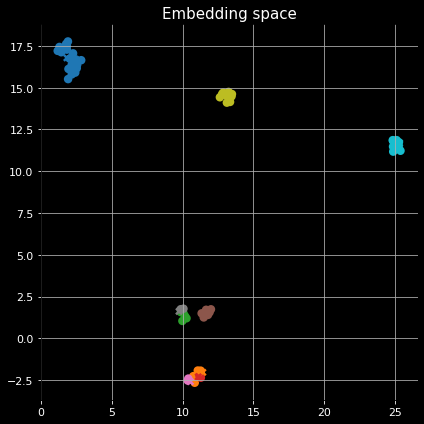

In [11]:
run_and_evaluate(
    embeddings_x, y = embeddings_y, k = range(3, 7), method = [
        'kmeans', 'spectral_clustering', {'method' : 'label_propagation', 'k_nearest' : 5}
    ], plot = True
)